In [325]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #This line is necessary on macbook s.t. models compile

plt.style.use('seaborn-colorblind')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data Prep and Cleaning

In [190]:
df = pd.read_csv('Part_1_Crime_Data.csv', low_memory = False)

In [191]:
df.head()

,X,Y,RowID,CrimeDateTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,...,Race,Ethnicity,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,VRIName,Total_Incidents
0,-76.5951,39.3232,1,2023/01/07 21:40:00+00,4A,1500 ABBOTSTON ST,AGG. ASSAULT,NaN,FIREARM,411,...,BLACK_OR_AFRICAN_AMERICAN,NaN,NORTHEAST,COLDSTREAM HOMESTEAD MONTEBELLO,39.3232,-76.5951,"(39.3232,-76.5951)",NaN,NaN,1
1,-76.6062,39.2933,2,2023/01/07 20:08:00+00,4E,300 N HIGH ST,COMMON ASSAULT,NaN,PERSONAL_WEAPONS,211,...,ASIAN,UNKNOWN,SOUTHEAST,JONESTOWN,39.2933,-76.6062,"(39.2933,-76.6062)",NaN,NaN,1
2,-76.5893,39.3378,3,2023/01/07 10:05:00+00,4E,1600 Roundhill Rd,COMMON ASSAULT,NaN,PERSONAL_WEAPONS,412,...,BLACK_OR_AFRICAN_AMERICAN,NOT_HISPANIC_OR_LATINO,NORTHEAST,HILLEN,39.3378,-76.5893,"(39.3378,-76.5893)",NaN,NaN,1
3,-76.6137,39.2884,4,2023/01/07 00:36:00+00,5F,0 LIGHT ST,BURGLARY,NaN,PERSONAL_WEAPONS,111,...,BLACK_OR_AFRICAN_AMERICAN,NOT_HISPANIC_OR_LATINO,CENTRAL,DOWNTOWN,39.2884,-76.6137,"(39.2884,-76.6137)",NaN,NaN,1
4,-76.6137,39.2884,5,2023/01/07 00:36:00+00,4E,0 LIGHT ST,COMMON ASSAULT,NaN,PERSONAL_WEAPONS,111,...,BLACK_OR_AFRICAN_AMERICAN,NaN,CENTRAL,DOWNTOWN,39.2884,-76.6137,"(39.2884,-76.6137)",NaN,NaN,1


In [192]:
df.columns.values

array(['X', 'Y', 'RowID', 'CrimeDateTime', 'CrimeCode', 'Location',
       'Description', 'Inside_Outside', 'Weapon', 'Post', 'Gender', 'Age',
       'Race', 'Ethnicity', 'District', 'Neighborhood', 'Latitude',
       'Longitude', 'GeoLocation', 'Premise', 'VRIName',
       'Total_Incidents'], dtype=object)

In [193]:
df.shape

(549687, 22)

In [194]:
codes = pd.read_csv('CRIME_CODES.csv')

In [195]:
codes

,CODE,TYPE,NAME,CLASS,NAME_COMBINE,WEAPON,VIOLENT_CR,VIO_PROP_CFS
0,13,CTYP,ASSIST OFFICER,CFS,ASSIST OFFICER,NaN,NaN,OTHER
1,1A,CTYP,MURDER,PART 1,HOMICIDE,OTHER,HOMICIDE,VIOLENT
2,1F,CTYP,MURDER,PART 1,HOMICIDE,FIREARM,HOMICIDE,VIOLENT
3,1K,CTYP,MURDER,PART 1,HOMICIDE,KNIFE,HOMICIDE,VIOLENT
4,1O,CTYP,MURDER,PART 1,HOMICIDE,OTHER,HOMICIDE,VIOLENT
...,...,...,...,...,...,...,...,...
198,BLNK,CTYP,NaN,NaN,NaN,NaN,NaN,OTHER
199,FI,CTYP,FIELD INTERVIEW,CFS,FIELD INTERVIEW,NaN,FIELD INTERVIEW,OTHER
200,RA,CTYP,REQUEST ASSISTANCE,CFS,REQUEST ASSISTANCE,NaN,NaN,OTHER
201,ZN,CTYP,FALSE ALARM,CFS,FALSE ALARM,NaN,NaN,PROPERTY


In [196]:
df = df.drop('X', axis = 1)
df = df.drop('Y', axis = 1)
df = df.drop('RowID', axis = 1)
df = df.drop('GeoLocation', axis = 1)
df = df.drop('Inside_Outside', axis = 1)
df = df.drop('Ethnicity', axis = 1)
df = df.drop('Premise', axis = 1)
df = df.drop('VRIName', axis = 1)
df = df.drop('District', axis = 1)
df = df.drop('Neighborhood', axis = 1)
df = df.drop('Location', axis = 1)
df = df.drop('Weapon', axis = 1)
df = df.drop('Post', axis = 1)
# df = df.dropna(axis = 0)

In [197]:
df.head()

,CrimeDateTime,CrimeCode,Description,Gender,Age,Race,Latitude,Longitude,Total_Incidents
0,2023/01/07 21:40:00+00,4A,AGG. ASSAULT,F,17.0,BLACK_OR_AFRICAN_AMERICAN,39.3232,-76.5951,1
1,2023/01/07 20:08:00+00,4E,COMMON ASSAULT,M,37.0,ASIAN,39.2933,-76.6062,1
2,2023/01/07 10:05:00+00,4E,COMMON ASSAULT,M,17.0,BLACK_OR_AFRICAN_AMERICAN,39.3378,-76.5893,1
3,2023/01/07 00:36:00+00,5F,BURGLARY,M,27.0,BLACK_OR_AFRICAN_AMERICAN,39.2884,-76.6137,1
4,2023/01/07 00:36:00+00,4E,COMMON ASSAULT,M,NaN,BLACK_OR_AFRICAN_AMERICAN,39.2884,-76.6137,1


In [198]:
df.shape

(549687, 9)

In [199]:
# df = df.dropna(axis = 0)

In [200]:
df.shape

(549687, 9)

In [201]:
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}: {count}')

CrimeDateTime: 0
CrimeCode: 0
Description: 0
Gender: 89147
Age: 110747
Race: 9604
Latitude: 899
Longitude: 899
Total_Incidents: 0


In [202]:
df = df.drop(df[df["Age"] > 200].index)
df = df.drop(df[df["Age"] < 0].index)

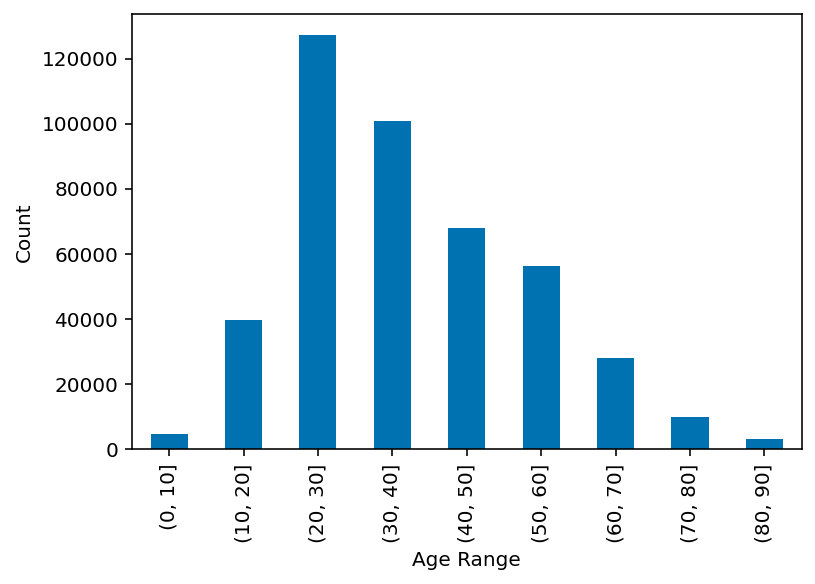

In [203]:
df2 = df.copy()

# Create age ranges by decade
df2['age_range'] = pd.cut(df['Age'], bins = list(np.arange(0,100,10)))

# Count occurences of age range
age_range_counts = df2['age_range'].value_counts()

# Sort by age range
age_range_counts = age_range_counts.sort_index()

age_range_counts.plot(kind = 'bar')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.show()

In [204]:
# Drop any data with an age range greater than 90
df = df.drop(df[df["Age"] > 90].index)

# Assume that any age data listed NaN was failed to be noted
df = df.dropna(subset = ['Age'])

# Drop any data with age lower than 18
df = df.drop(df[df["Age"] < 18].index)

In [205]:
df.shape

(413225, 9)

In [206]:
df = df.dropna(axis = 0)

print(df.shape)

(398474, 9)


In [207]:
df.head()

,CrimeDateTime,CrimeCode,Description,Gender,Age,Race,Latitude,Longitude,Total_Incidents
1,2023/01/07 20:08:00+00,4E,COMMON ASSAULT,M,37.0,ASIAN,39.2933,-76.6062,1
3,2023/01/07 00:36:00+00,5F,BURGLARY,M,27.0,BLACK_OR_AFRICAN_AMERICAN,39.2884,-76.6137,1
5,2023/01/07 05:00:00+00,6G,LARCENY,F,53.0,WHITE,39.2940,-76.5864,1
6,2023/01/07 08:58:00+00,6F,LARCENY,F,43.0,BLACK_OR_AFRICAN_AMERICAN,39.2970,-76.5814,1
7,2023/01/07 04:00:00+00,7A,AUTO THEFT,F,22.0,BLACK_OR_AFRICAN_AMERICAN,39.3267,-76.5484,1


In [230]:
df['CrimeDateTime'] = pd.to_datetime(df['CrimeDateTime'], errors = 'coerce')

df = df.dropna()

# Convert the date-time columns to a nice format
df.loc[:, 'date'] = df['CrimeDateTime'].dt.strftime("%d%m%Y")
df.loc[:, 'time'] = df['CrimeDateTime'].dt.strftime("%H%M%S")

# Convert the columns to integer values
df['date'].astype(int)
df['time'].astype(int)

In [227]:
df['date'] = df['date'].astype(int)
df['time'] = df['time'].astype(int)

In [209]:
df.shape

(398473, 11)

In [210]:
df.head()

,CrimeDateTime,CrimeCode,Description,Gender,Age,Race,Latitude,Longitude,Total_Incidents,date,time
1,2023-01-07 20:08:00+00:00,4E,COMMON ASSAULT,M,37.0,ASIAN,39.2933,-76.6062,1,07012023,200800
3,2023-01-07 00:36:00+00:00,5F,BURGLARY,M,27.0,BLACK_OR_AFRICAN_AMERICAN,39.2884,-76.6137,1,07012023,003600
5,2023-01-07 05:00:00+00:00,6G,LARCENY,F,53.0,WHITE,39.2940,-76.5864,1,07012023,050000
6,2023-01-07 08:58:00+00:00,6F,LARCENY,F,43.0,BLACK_OR_AFRICAN_AMERICAN,39.2970,-76.5814,1,07012023,085800
7,2023-01-07 04:00:00+00:00,7A,AUTO THEFT,F,22.0,BLACK_OR_AFRICAN_AMERICAN,39.3267,-76.5484,1,07012023,040000


In [211]:
df = df.drop('CrimeDateTime', axis = 1)
df = df.drop('CrimeCode', axis = 1)
df = df.drop('Race', axis = 1)
df = df.drop('Description', axis = 1)

In [212]:
df.head()

,Gender,Age,Latitude,Longitude,Total_Incidents,date,time
1,M,37.0,39.2933,-76.6062,1,07012023,200800
3,M,27.0,39.2884,-76.6137,1,07012023,003600
5,F,53.0,39.2940,-76.5864,1,07012023,050000
6,F,43.0,39.2970,-76.5814,1,07012023,085800
7,F,22.0,39.3267,-76.5484,1,07012023,040000


In [213]:
# Print the total number of rows where total incidents is greater than 1
count = df.loc[df['Total_Incidents'] > 1].shape[0]

print(count)

0


In [214]:
#Then we can drop this column
df = df.drop('Total_Incidents', axis = 1)

In [219]:
# Convert age column to integer
df['Age'] = df['Age'].astype(int)

# Convert Gender column to binary, M = 0, F = 1
df['Gender'] = pd.Series(np.where(df.Gender.values == 'M', 0, 1), df.index)

In [231]:
#Double check to make sure that all values are np float/int
print(type(df['Longitude'].iloc[50]))
print(type(df['Gender'].iloc[50]))
print(type(df['date'].iloc[50]))
print(type(df['time'].iloc[50]))

<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [222]:
df.head()

,Gender,Age,Latitude,Longitude,date,time
1,0,37,39.2933,-76.6062,07012023,200800
3,0,27,39.2884,-76.6137,07012023,003600
5,1,53,39.2940,-76.5864,07012023,050000
6,1,43,39.2970,-76.5814,07012023,085800
7,1,22,39.3267,-76.5484,07012023,040000


In [ ]:
df.shape

# Prediction Modelling

In [250]:
# Here we are training on everything except the location data
X = df.drop(['Latitude', 'Longitude'], axis=1)
y = df[['Latitude', 'Longitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [260]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Standardize the training and test data
X_training_scaled = scaler.fit_transform(X_train)
y_training_scaled = scaler.fit_transform(y_train)

X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = scaler.fit_transform(y_test)

In [252]:
# Creating the model
model = Sequential()
model.add(Dense(64, input_shape = (4,), activation = 'relu'))

# Adding the hidden layers
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

# Output Layer
model.add(Dense(2, activation = 'softmax'))

In [261]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [268]:
model.fit(X_training_scaled, y_training_scaled, epochs = 10, batch_size = 32)

Epoch 1/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 2/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 3/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 4/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 5/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 6/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 7/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 8/10
9962/9962 [==============================] - 11s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 9/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431
Epoch 10/10
9962/9962 [==============================] - 12s 1ms/step - loss: nan - accuracy: 0.9431

In [269]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                320       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 2)                 130       
                                                                 
Total params: 12,930
Trainable params: 12,930
Non-trainable params: 0
_________________________________________________________________


In [255]:
# This is quite bad, our loss is large initially and then explodes towards infinity.
# Change the model and account for this

In [284]:
# Creating the model, and attempting an initialization using Glorot
model = Sequential()
model.add(Dense(64, input_shape = (4,), activation = 'relu', kernel_initializer='glorot_uniform'))

# Adding the hidden layers
model.add(Dense(64, activation = 'relu', kernel_initializer='glorot_uniform'))
model.add(Dense(64, activation = 'relu', kernel_initializer='glorot_uniform'))
model.add(Dense(64, activation = 'relu', kernel_initializer='glorot_uniform'))

# Output Layer
model.add(Dense(2, activation = 'softmax'))

In [285]:
optimizer = tf.optimizers.Adam(learning_rate = 0.01)

In [286]:
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

In [287]:
model.fit(X_train_scaled, y_train_scaled, epochs = 10, batch_size = 32)

Epoch 1/10
9962/9962 [==============================] - 12s 1ms/step - loss: 3782.0520 - accuracy: 0.0000e+00
Epoch 2/10
9962/9962 [==============================] - 12s 1ms/step - loss: 3782.0515 - accuracy: 0.0000e+00
Epoch 3/10
9962/9962 [==============================] - 12s 1ms/step - loss: 3782.0439 - accuracy: 0.0000e+00
Epoch 4/10
9962/9962 [==============================] - 12s 1ms/step - loss: 3782.0559 - accuracy: 0.0000e+00
Epoch 5/10
9962/9962 [==============================] - 12s 1ms/step - loss: 3782.0427 - accuracy: 0.0000e+00
Epoch 6/10
9962/9962 [==============================] - 13s 1ms/step - loss: 3782.0422 - accuracy: 0.0000e+00
Epoch 7/10
9962/9962 [==============================] - 12s 1ms/step - loss: 3782.0466 - accuracy: 0.0000e+00
Epoch 8/10
9962/9962 [==============================] - 11s 1ms/step - loss: 3782.0476 - accuracy: 0.0000e+00
Epoch 9/10
9962/9962 [==============================] - 11s 1ms/step - loss: 3782.0520 - accuracy: 0.0000e+00
Epoch 10/1

In [288]:
model.evaluate(X_test_scaled, y_test_scaled)

2491/2491 [==============================] - 2s 798us/step - loss: 1.2519 - accuracy: 0.0655


[1.2519404888153076, 0.06549971550703049]

# Attempt to do this but with a validation set included

In [292]:
(df.shape[0] / 10) * 6

239083.80000000002

In [305]:
X = df.drop(['Latitude', 'Longitude'], axis=1)
y = df[['Latitude', 'Longitude']]

X_train = X[:239084]
y_train = y[:239084]

X_valid = X[239084:318778]
y_valid = y[239084:318778]

X_test = X[318778:]
y_test = y[318778:]

In [311]:
# Fit the scaler to the training data
scaler.fit(X_train)

# Standardize the training and test data
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)

X_val_scaled = scaler.fit_transform(X_valid)
y_val_scaled = scaler.fit_transform(y_valid)

X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = scaler.fit_transform(y_test)

In [307]:
optimizer = tf.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

In [314]:
model.fit(X_train_scaled, y_train_scaled, validation_data = (X_val_scaled, y_val_scaled), 
          epochs = 10, batch_size = 32)

Epoch 1/10
7472/7472 [==============================] - 10s 1ms/step - loss: 1.2507 - accuracy: 0.5480 - val_loss: 1.2507 - val_accuracy: 0.0411
Epoch 2/10
7472/7472 [==============================] - 10s 1ms/step - loss: 1.2505 - accuracy: 0.5456 - val_loss: 1.2504 - val_accuracy: 0.9589
Epoch 3/10
7472/7472 [==============================] - 10s 1ms/step - loss: 1.2504 - accuracy: 0.5521 - val_loss: 1.2503 - val_accuracy: 0.0411
Epoch 4/10
7472/7472 [==============================] - 10s 1ms/step - loss: 1.2504 - accuracy: 0.5221 - val_loss: 1.2500 - val_accuracy: 0.9589
Epoch 5/10
7472/7472 [==============================] - 10s 1ms/step - loss: 1.2504 - accuracy: 0.5639 - val_loss: 1.2537 - val_accuracy: 0.0411
Epoch 6/10
7472/7472 [==============================] - 11s 1ms/step - loss: 1.2504 - accuracy: 0.5513 - val_loss: 1.2510 - val_accuracy: 0.0411
Epoch 7/10
7472/7472 [==============================] - 10s 1ms/step - loss: 1.2505 - accuracy: 0.5247 - val_loss: 1.2502 - val_ac

In [315]:
model.evaluate(X_test_scaled, y_test_scaled)

2491/2491 [==============================] - 2s 816us/step - loss: 1.2509 - accuracy: 0.0018


[1.2509273290634155, 0.0017817930784076452]

# Attempt a randomized search for best parameters

In [316]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [317]:
param_distribs = {
    "n_hidden": [0,1,2,3],
    "n_neurons": np.arange(50,125),
    "learning_rate": reciprocal(3e-4, 3e-2, 1.5e-2),
}

In [329]:
# Here we build the same model that we did before
def build_model(n_hidden = 4, n_neurons = 64, learning_rate = 1e-3, input_shape=(4,)):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for i in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [330]:
keras_reg = KerasRegressor(build_model)

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_5838/2428896498.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_model)


In [331]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter = 10, cv = 3)

In [333]:
rnd_search_cv.fit(X_train_scaled, y_train_scaled, epochs = 15, validation_data = (X_val_scaled, y_val_scaled),
                 callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5)])

Epoch 1/15
4981/4981 [==============================] - 11s 2ms/step - loss: 0.9214 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/15
4981/4981 [==============================] - 9s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/15
4981/4981 [==============================] - 9s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/15
4981/4981 [==============================] - 11s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/15
4981/4981 [==============================] - 9s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 7/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.9212 - 

4981/4981 [==============================] - 7s 1ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 9/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 10/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 11/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 12/15
4981/4981 [==============================] - 9s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 13/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 14/15
4981/4981 [==============================] - 7s 1ms/step - loss: 0.9212 - accuracy:

2491/2491 [==============================] - 3s 1ms/step - loss: 0.6322 - accuracy: 0.0000e+00
Epoch 1/15
4981/4981 [==============================] - 12s 2ms/step - loss: 0.9233 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/15
4981/4981 [==============================] - 9s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/15
4981/4981 [==============================] - 9s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0

Epoch 11/15
4981/4981 [==============================] - 9s 2ms/step - loss: 1.1839 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 12/15
2491/2491 [==============================] - 3s 1ms/step - loss: 0.6322 - accuracy: 0.0000e+00
Epoch 1/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.9215 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0001 - val_accuracy: 0.0000e+00
Epoch 4/15
4981/4981 [==============================] - 9s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.9212 - accuracy: 0.0000e+00 - val_loss: 1.0000 - v

2491/2491 [==============================] - 3s 1ms/step - loss: 1.1576 - accuracy: 0.0000e+00
Epoch 1/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.8955 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.8949 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/15
4981/4981 [==============================] - 10s 2ms/step - loss: 0.8949 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.8949 - accuracy: 0.0000e+00 - val_loss: 1.0002 - val_accuracy: 0.0000e+00
Epoch 5/15
4981/4981 [==============================] - 8s 2ms/step - loss: 0.8949 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/15
2491/2491 [==============================] - 3s 1ms/step - loss: 1.2102 - accuracy: 0.0000e+00
Epoch 1/15
4981/4981 [===============

2491/2491 [==============================] - 2s 745us/step - loss: 0.6323 - accuracy: 0.0000e+00
Epoch 1/15
4981/4981 [==============================] - 6s 1ms/step - loss: 0.9241 - accuracy: 0.0000e+00 - val_loss: 1.0001 - val_accuracy: 0.0000e+00
Epoch 2/15
4981/4981 [==============================] - 6s 1ms/step - loss: 0.9213 - accuracy: 0.0000e+00 - val_loss: 1.0002 - val_accuracy: 0.0000e+00
Epoch 3/15
4981/4981 [==============================] - 6s 1ms/step - loss: 0.9213 - accuracy: 0.0000e+00 - val_loss: 1.0001 - val_accuracy: 0.0000e+00
Epoch 4/15
4981/4981 [==============================] - 6s 1ms/step - loss: 0.9213 - accuracy: 0.0000e+00 - val_loss: 1.0002 - val_accuracy: 0.0000e+00
Epoch 5/15
4981/4981 [==============================] - 6s 1ms/step - loss: 0.9213 - accuracy: 0.0000e+00 - val_loss: 1.0005 - val_accuracy: 0.0000e+00
Epoch 6/15
4981/4981 [==============================] - 6s 1ms/step - loss: 0.9213 - accuracy: 0.0000e+00 - val_loss: 1.0001 - val_accuracy: 0.

7472/7472 [==============================] - 9s 1ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f80c8298c40>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f80aac25280>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124])})

In [334]:
rnd_search_cv.best_params_

{'learning_rate': 0.018060925531338468, 'n_hidden': 3, 'n_neurons': 54}

In [335]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
def build_model(n_hidden = 8, n_neurons = 54, learning_rate = 18.06e-3, input_shape=(4,)):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for i in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['accuracy'])
    return model